In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss

In [2]:
final_data = pd.read_csv("")

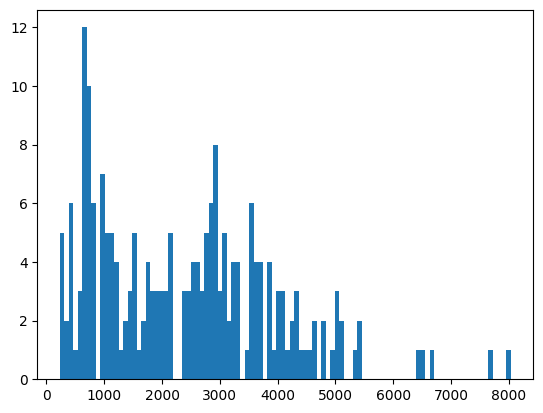

In [7]:
T = final_data["SURVIVAL_TIME"]
E = final_data["EVENT"]
plt.hist(T, bins=100)
plt.show()

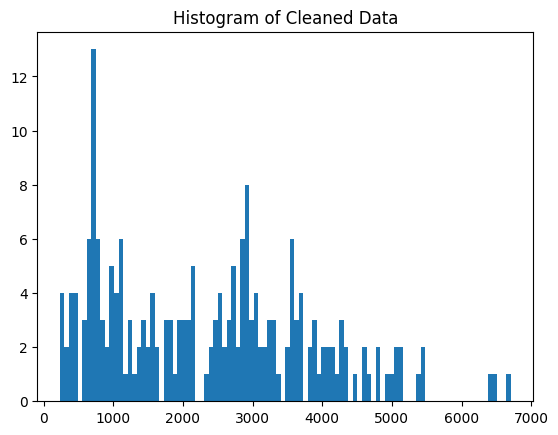

In [26]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(T, 25)
Q3 = np.percentile(T, 75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
E = E[(T >= lower_bound) & (T<= upper_bound)]
T = T[(T >= lower_bound) & (T <= upper_bound)]
final_data = final_data[(final_data["SURVIVAL_TIME"] >= lower_bound) & (final_data["SURVIVAL_TIME"] <= upper_bound)]


# Plot the cleaned data
plt.hist(T, bins=100)
plt.title('Histogram of Cleaned Data')
plt.show()

## Kaplan Meier curves

### KM general curve, without taking variables into consideration

The first step was to fit a Kaplan Meier model to the previously cleaned dataset to see the general survival time of the road sections.

Text(0, 0.5, 'Survival probability')

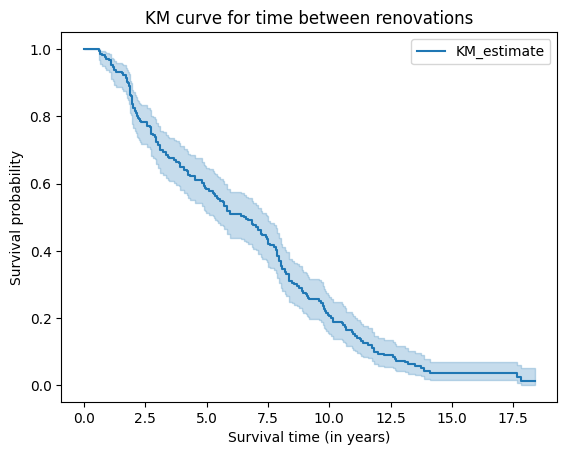

In [30]:
# Normal Kaplan Meier curve of the overall data

kmf = KaplanMeierFitter()
kmf.fit(durations=T/365, event_observed = E)
kmf.plot_survival_function()
plt.title("KM curve for time between renovations")
plt.xlabel("Survival time (in years)")
plt.ylabel("Survival probability")

Check the median survival time and confidence intervals

In [14]:
# Median survival time and confidence intervals

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print(f"The median survival time is: {median_}")
print(f"The median confidence interval is: {median_confidence_interval_}")

The median survival time is: 6.52054794520548
The median confidence interval is:      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                5.284932                 7.50137


As it is possible to notice the survival probability decrease gradually over time, until reaching really low values after around 10 years.

The median survival time (MST) (the time at which 50% of the onservation fail, when the survival probability is equal to 0.5) is of 6.52 years, suggesting that a road segment needs renovation, on average, every 6 years and 6 months. 

The median confidence interval suggests that we are 95% confident that the true MST lies between 5.28 and 7.50 years.

### KM curves based on traffic intensity categories

The next step was to estimate the survival curves for two different traffic intensity categories based on the ESAL index:

- high_esal: observations in which the ESAL value is higher than 200000 
- low_esal: observations in which the ESAL value is lower than 200000

Text(0.5, 0, 'Timeline (years)')

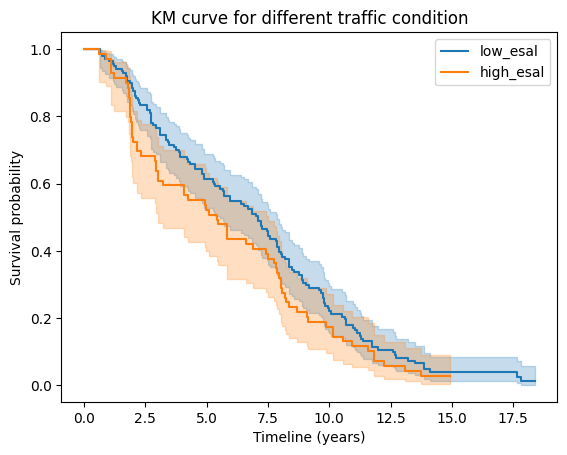

In [21]:
# KM plot for esal intensity

ax = plt.subplot(111)
l = (final_data["esal_cat"] == "low_esal")
h = (final_data["esal_cat"] == "high_esal")
km_low = kmf.fit(durations = T[l]/365, event_observed = E[l], label = "low_esal")
kmf.plot_survival_function(ax=ax)
median_survival_low = kmf.median_survival_time_
median_confidence_interval_low = median_survival_times(kmf.confidence_interval_)
km_high = kmf.fit(durations = T[h]/365, event_observed = E[h], label = "high_esal")
kmf.plot_survival_function(ax=ax)
median_survival_high = kmf.median_survival_time_
median_confidence_interval_high = median_survival_times(kmf.confidence_interval_)
plt.title("KM curve for different traffic condition")
plt.ylabel("Survival probability")
plt.xlabel("Timeline (years)")

From the figure it is possible to notice that road segments where the traffic intensity is on average higher (orange curve) tend to have lower survival times with respect to the other observations.

In [22]:

print(f"MST for sections with low traffic intensity: {median_survival_low}")
print(f"MST for sections with high traffic intensity: {median_survival_high}")
print(f"CI for low traffic intensity: {median_confidence_interval_low}")
print(f"CI for low traffic intensity: {median_confidence_interval_high}")

MST for sections with low traffic intensity: 7.079452054794521
MST for sections with high traffic intensity: 5.427397260273972
CI for low traffic intensity:      low_esal_lower_0.95  low_esal_upper_0.95
0.5             5.534247             7.882192
CI for low traffic intensity:      high_esal_lower_0.95  high_esal_upper_0.95
0.5              3.030137              7.512329


The MST values suggest that if a road segment has a high ESAL value it will need renovation around 1.5 year earlier than those with more moderate traffic conditions. 

We can therefore suppose that traffic intensity has an impact on the survival time of the pavement.

#### Concordance Index

In order to evaluate the performance of the model the concordance index was calculated.

The concordance index (C-index) is a measure of the predictive accuracy of a survival model. It evaluates how well the model predicts the order of events (in this case the occured maintenance) relative to the actual observed times

In [27]:
# Calculate the concordance index
# Create a predicted risk score array based on 'esal_cat' category
# Here we use 0 for 'low_esal' and 1 for 'high_esal'
risk_scores = np.where(final_data["esal_cat"] == "low_esal", 0, 1)

# Calculate the C-index
c_index = concordance_index(T, -risk_scores, E)
print("Concordance Index:", c_index)

Concordance Index: 0.5357091154755586


In this case a C-index of 0.54 indicate a limited predicted power of the model

### KM curves based on weather condition

Another interesting variable to analyze to see the effect on survival time was the weather condition the road section has to face during the year.

The decision was made to create 3 different categories:

- cold_region: road sections situated in regions where the average temperature is below 0 degrees Celsius for at least 100 days a year
- hot_regions: road sections located in climate zones in which the average temperature is higher then 32 degrees Celsius for at least 100 days a year
- mitigate_regions: road sections that do not present extreme weather conditions

Text(0.5, 0, 'Timeline (years)')

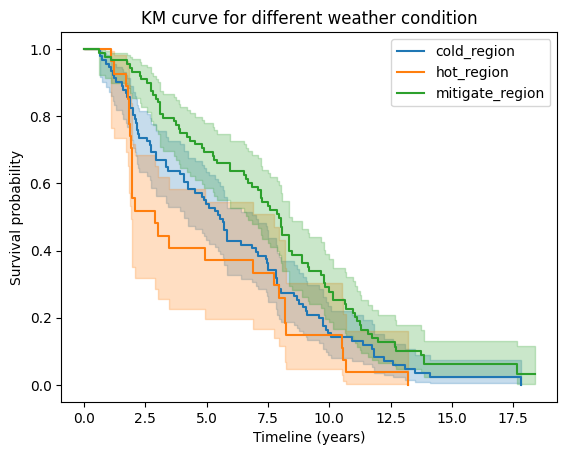

In [31]:
# KM plot for weather regions

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
c = (final_data["weather_type"] == "cold_region")
h = (final_data["weather_type"] == "hot_region")
m = (final_data["weather_type"] == "mitigate_region")
kmf.fit(durations = T[c]/365, event_observed = E[c], label = "cold_region")
kmf.plot_survival_function(ax=ax)
median_survival_cold = kmf.median_survival_time_
median_confidence_interval_cold = median_survival_times(kmf.confidence_interval_)
kmf.fit(durations = T[h]/365, event_observed = E[h], label = "hot_region")
kmf.plot_survival_function(ax=ax)
median_survival_hot = kmf.median_survival_time_
median_confidence_interval_hot = median_survival_times(kmf.confidence_interval_)
kmf.fit(durations = T[m]/365, event_observed = E[m], label = "mitigate_region")
kmf.plot_survival_function(ax=ax)
median_survival_mit = kmf.median_survival_time_
median_confidence_interval_mit = median_survival_times(kmf.confidence_interval_)
plt.title("KM curve for different weather condition")
plt.ylabel("Survival probability")
plt.xlabel("Timeline (years)")

Median survival times and confidence intervals

In [32]:
print(f"MST for sections located in hot regions: {median_survival_hot}")
print(f"MST for sections located in cold regions: {median_survival_cold}")
print(f"MST for sections located in mitigate regions: {median_survival_mit}")
print(f"CI for sections located in hot regions: {median_confidence_interval_hot}")
print(f"CI for sections located in cold regions: {median_confidence_interval_cold}")
print(f"CI for sections located in mitigate regions: {median_confidence_interval_mit}")

MST for sections located in hot regions: 2.9068493150684933
MST for sections located in cold regions: 5.534246575342466
MST for sections located in mitigate regions: 7.972602739726027
CI for sections located in hot regions:      hot_region_lower_0.95  hot_region_upper_0.95
0.5                1.90411               7.753425
CI for sections located in cold regions:      cold_region_lower_0.95  cold_region_upper_0.95
0.5                4.084932                7.013699
CI for sections located in mitigate regions:      mitigate_region_lower_0.95  mitigate_region_upper_0.95
0.5                    6.682192                    8.465753


Concordance index

In [33]:
# Assign risk scores for the concordance index calculation
# Example: 0 for cold_region, 1 for hot_region, 2 for mitigate_region
risk_scores = final_data["weather_type"].map({
    "cold_region": 2,
    "hot_region": 1,
    "mitigate_region": 0
})

# Calculate the concordance index
c_index = concordance_index(T, -risk_scores, E)
print("Concordance Index:", c_index)

Concordance Index: 0.5627563576702215


## Bayesian Survival model

### BSM for different traffic intensities

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, lambda, intercept, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.


               mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta          0.161     0.091   -0.013     0.326      0.001    0.001   
intercept     7.796     0.076    7.652     7.938      0.001    0.001   
lambda     4101.965  2194.372  959.844  8023.201     30.427   23.133   
rho           1.598     0.087    1.436     1.765      0.001    0.001   

           ess_bulk  ess_tail  r_hat  
beta         4266.0    4548.0    1.0  
intercept    4565.0    4638.0    1.0  
lambda       5698.0    4949.0    1.0  
rho          6613.0    4874.0    1.0  


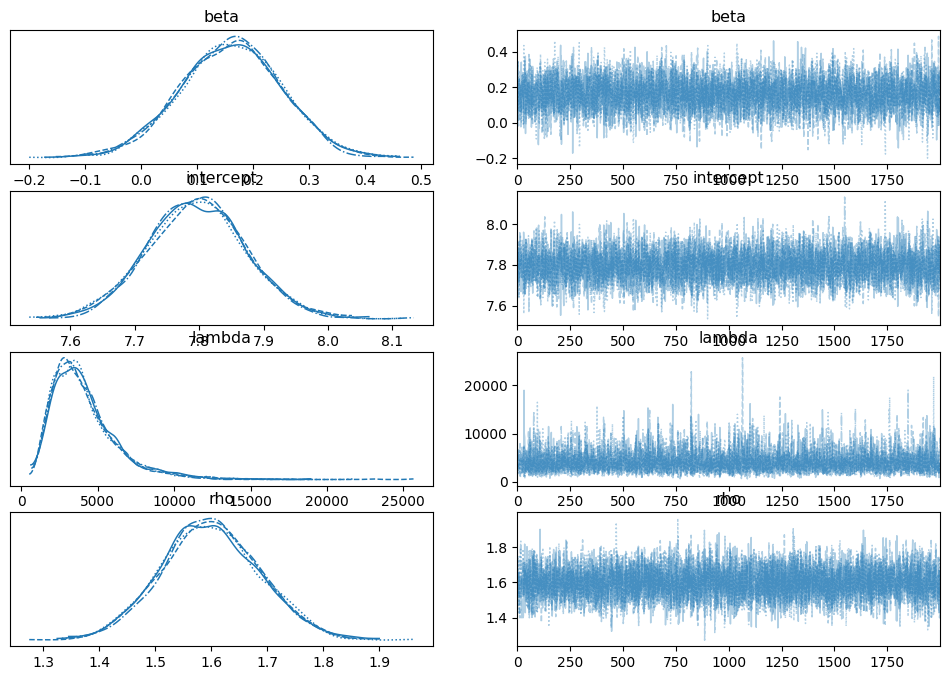

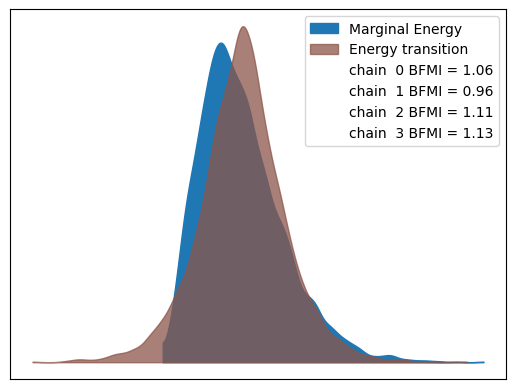

               mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta          0.161     0.091   -0.013     0.326      0.001    0.001   
intercept     7.796     0.076    7.652     7.938      0.001    0.001   
lambda     4101.965  2194.372  959.844  8023.201     30.427   23.133   
rho           1.598     0.087    1.436     1.765      0.001    0.001   

           ess_bulk  ess_tail  r_hat  
beta         4266.0    4548.0    1.0  
intercept    4565.0    4638.0    1.0  
lambda       5698.0    4949.0    1.0  
rho          6613.0    4874.0    1.0  


In [34]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('')
data['esal_cat_encoded'] = data['esal_cat'].astype('category').cat.codes

# Convert prior median and standard deviation into scale and shape parameters for Weibull
prior_median = 3000
prior_sd = 400

# Initial guesses for lambda and rho
initial_lambda = prior_median / (np.log(2))**(1/2)  # Assume initial shape parameter 2
initial_rho = 2

with pm.Model() as model:
    # Informative priors based on prior studies
    rho = pm.Gamma('rho', alpha=initial_rho**2 / (prior_sd**2), beta=initial_rho / (prior_sd**2))
    lambda_ = pm.Lognormal('lambda', mu=np.log(initial_lambda), sigma=0.5)
    
    # Linear model for the scale parameter
    intercept = pm.Normal('intercept', mu=np.log(initial_lambda), sigma=0.5)
    beta = pm.Normal('beta', mu=0, sigma=1)
    
    theta = intercept + beta * data['esal_cat_encoded']
    lambda_ = pm.math.exp(theta)

    # Observed survival times and event indicators
    T_obs = data['SURVIVAL_TIME']
    is_observed = data['EVENT'].values

    lambda_observed = lambda_[is_observed == 1]
    lambda_censored = lambda_[is_observed == 0]
    T_obs_censored = T_obs[is_observed == 0]
    T_obs_observed = T_obs[is_observed == 1]

    # Likelihood for observed data
    survival = pm.Weibull('survival', alpha=rho, beta=lambda_observed, observed=T_obs_observed)
    
    # Potential for censored data
    censored_dist = pm.Weibull.dist(alpha=rho, beta=lambda_censored)
    censored = pm.Potential('censored', pm.logp(censored_dist, T_obs_censored))

    # Sampling
    trace = pm.sample(2000, tune=2000, nuts={'target_accept': 0.95, 'max_treedepth': 15})

# Trace summary
summary = pm.summary(trace)
print(summary)

# Checking convergence and diagnostics
import arviz as az
az.plot_trace(trace)
plt.show()

az.plot_energy(trace)
plt.show()

# Summary with diagnostics
summary = az.summary(trace)
print(summary)


In [35]:
np.exp(trace.posterior["beta"]).mean()

<xarray.DataArray 'beta' ()> Size: 8B
array(1.17944015)

<Axes: title={'center': 'beta'}>

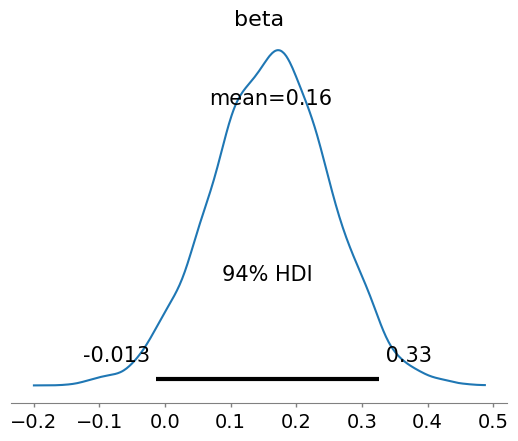

In [36]:
az.plot_posterior(trace, var_names=["beta"])

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'beta\n3'}>], dtype=object)

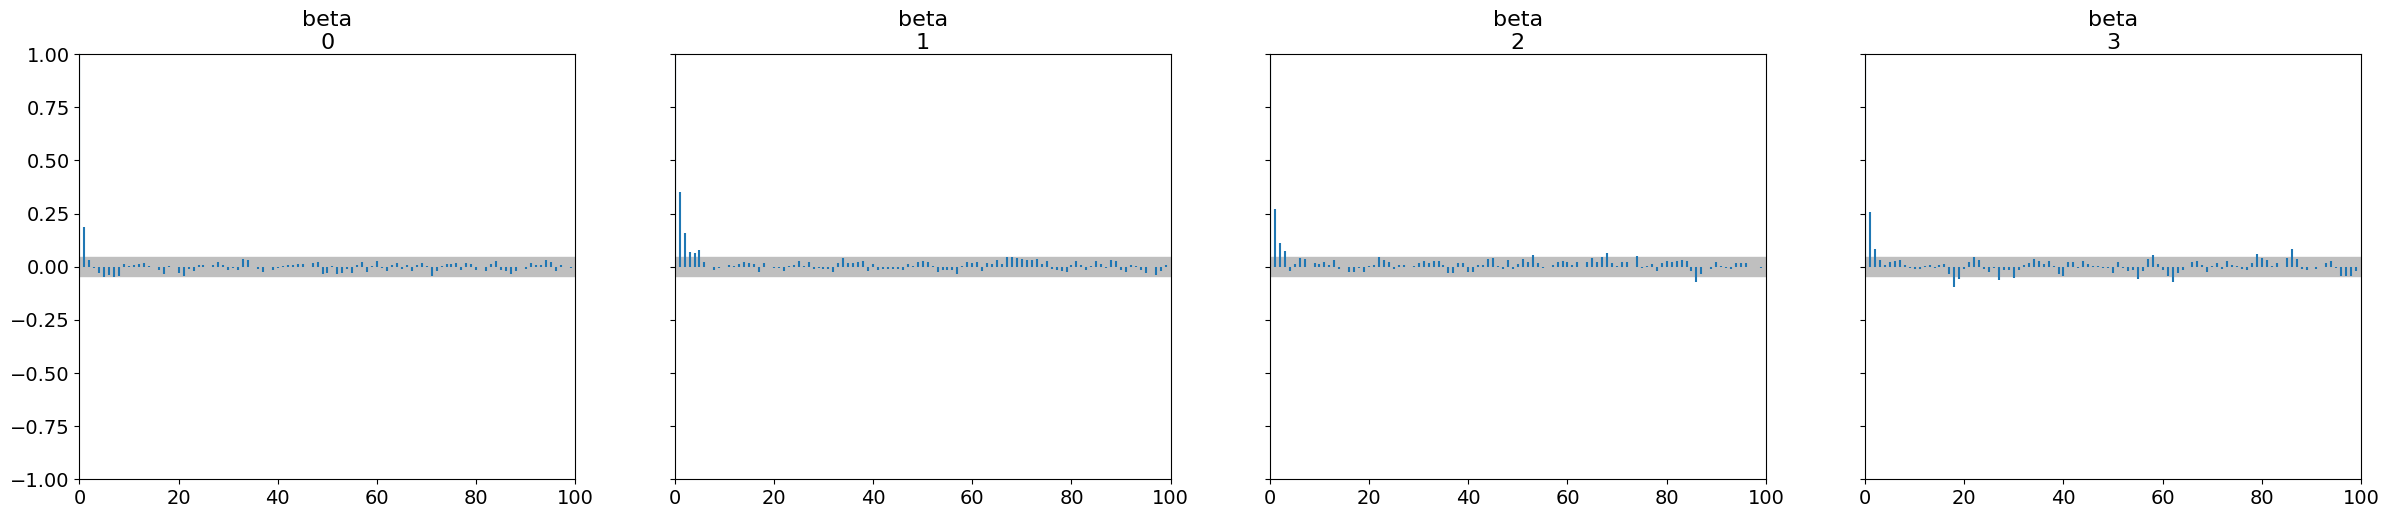

In [37]:
az.plot_autocorr(trace, var_names=["beta"])

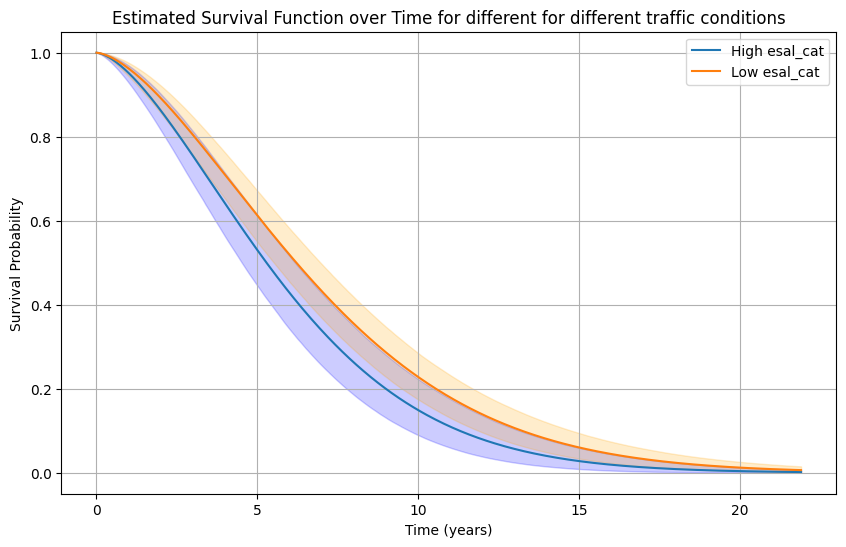

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Define the Weibull survival function
def weibull_survival_function(time, alpha, lambda_):
    return np.exp(-(time[:, None] / lambda_)**alpha)

# Define time points for evaluation
time_points_days = np.linspace(1, 8000, 500)
time_points_years = time_points_days / 365.25  # Convert days to years

# Extract posterior samples
alpha_samples = trace.posterior['rho'].values.flatten()
intercept_samples = trace.posterior['intercept'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()

# Calculate lambda for each category
lambda_samples_high = np.exp(intercept_samples + beta_samples * 0)
lambda_samples_low = np.exp(intercept_samples + beta_samples * 1)

# Calculate the survival function over time for both categories
survival_high = weibull_survival_function(time_points_days, alpha_samples, lambda_samples_high)
survival_low = weibull_survival_function(time_points_days, alpha_samples, lambda_samples_low)

# Calculate mean survival function and 95% credible intervals
mean_survival_high = np.mean(survival_high, axis=1)
mean_survival_low = np.mean(survival_low, axis=1)
ci_survival_high = np.percentile(survival_high, [2.5, 97.5], axis=1)
ci_survival_low = np.percentile(survival_low, [2.5, 97.5], axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points_years, mean_survival_high, label='High esal_cat')
plt.plot(time_points_years, mean_survival_low, label='Low esal_cat')
plt.fill_between(time_points_years, ci_survival_high[0], ci_survival_high[1], color='blue', alpha=0.2)
plt.fill_between(time_points_years, ci_survival_low[0], ci_survival_low[1], color='orange', alpha=0.2)
plt.xlabel('Time (years)')
plt.ylabel('Survival Probability')
plt.title('Estimated Survival Function over Time for different for different traffic conditions')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/ww/szy97qs14cx3rrnpgz1cymgr0000gp/T/ipykernel_81093/3167453951.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace, var_names=['survival'], model=model)
Sampling: [survival]


Output()

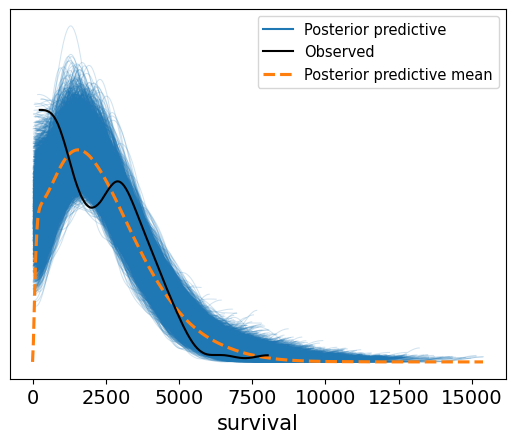

In [39]:
# Posterior Predictive Checks
ppc = pm.sample_posterior_predictive(trace, var_names=['survival'], model=model)

# Plot PPC
az.plot_ppc(ppc)
plt.show()

In [41]:
# Calculate the concordance index

import numpy as np
from lifelines.utils import concordance_index

# Compute hazard rates using broadcasting
esal_cat_encoded = data['esal_cat_encoded'].values[None, None, :]  # Add axes for chain and draw

intercept = trace["posterior"]['intercept'].values
beta = trace["posterior"]['beta'].values

# Ensure the computation uses correct dimensions for broadcasting
hazard_rates_posterior = np.exp(intercept[:, :, None] + beta[:, :, None] * esal_cat_encoded)

# Compute the median across both chains and samples, maintaining the individual observations
median_hazards = np.median(hazard_rates_posterior, axis=(0, 1)) 

# calculate the concordance index
c_index = concordance_index(event_times=data['SURVIVAL_TIME'],
                            event_observed=data['EVENT'],
                            predicted_scores=median_hazards)

print(f'Concordance Index: {c_index}')

Concordance Index: 0.5382192753966375


### BSM for different weather conditions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, lambda, intercept, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


               mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta[0]      -0.178     0.138   -0.438     0.080      0.002    0.001   
beta[1]       0.240     0.091    0.072     0.412      0.001    0.001   
intercept     7.815     0.066    7.697     7.942      0.001    0.001   
lambda     4104.298  2214.125  989.634  8031.781     28.111   21.058   
rho           1.624     0.090    1.461     1.797      0.001    0.001   

           ess_bulk  ess_tail  r_hat  
beta[0]      4792.0    5077.0    1.0  
beta[1]      4546.0    4989.0    1.0  
intercept    4112.0    5240.0    1.0  
lambda       6603.0    5451.0    1.0  
rho          6494.0    5665.0    1.0  


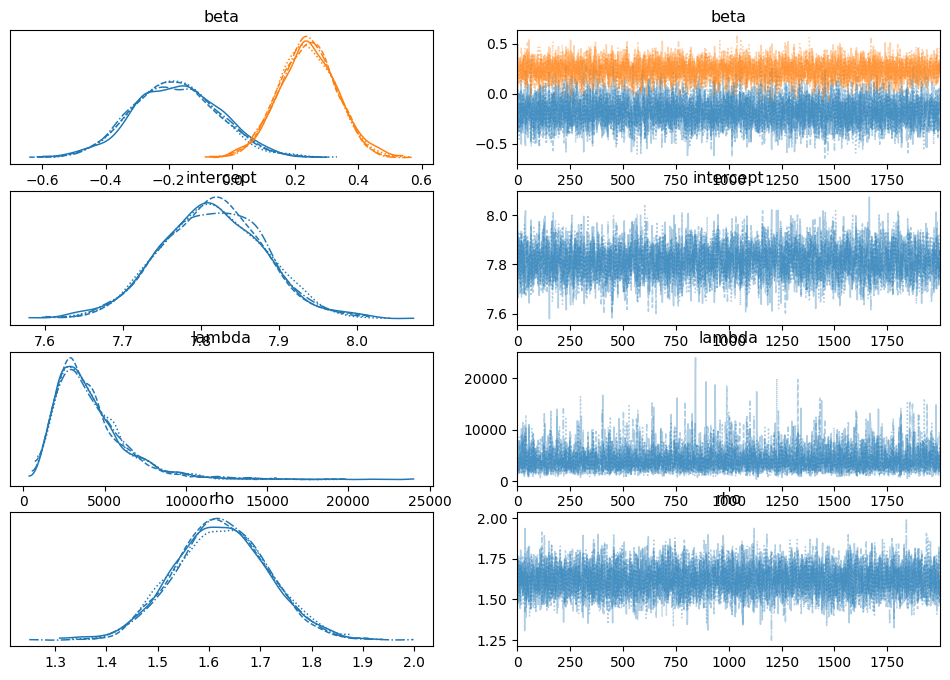

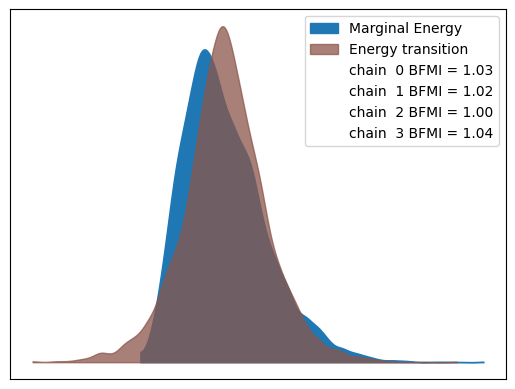

               mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta[0]      -0.178     0.138   -0.438     0.080      0.002    0.001   
beta[1]       0.240     0.091    0.072     0.412      0.001    0.001   
intercept     7.815     0.066    7.697     7.942      0.001    0.001   
lambda     4104.298  2214.125  989.634  8031.781     28.111   21.058   
rho           1.624     0.090    1.461     1.797      0.001    0.001   

           ess_bulk  ess_tail  r_hat  
beta[0]      4792.0    5077.0    1.0  
beta[1]      4546.0    4989.0    1.0  
intercept    4112.0    5240.0    1.0  
lambda       6603.0    5451.0    1.0  
rho          6494.0    5665.0    1.0  


In [42]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('')
data = pd.get_dummies(data, columns=['weather_type'], drop_first=True)

# Convert prior median and standard deviation into scale and shape parameters for Weibull
prior_median = 3000
prior_sd = 400

# Initial guesses for lambda and rho
initial_lambda = prior_median / (np.log(2))**(1/2)  # Assume initial shape parameter 2
initial_rho = 2

# Extract dummy variables for weather_type
weather_dummies = data[['weather_type_hot_region', 'weather_type_mitigate_region']].values

with pm.Model() as model:
    # Informative priors based on prior studies
    rho = pm.Gamma('rho', alpha=initial_rho**2 / (prior_sd**2), beta=initial_rho / (prior_sd**2))
    lambda_ = pm.Lognormal('lambda', mu=np.log(initial_lambda), sigma=0.5)
    
    # Linear model for the scale parameter
    intercept = pm.Normal('intercept', mu=np.log(initial_lambda), sigma=0.5)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=weather_dummies.shape[1])
    
    theta = intercept + pm.math.dot(weather_dummies, beta)
    lambda_ = pm.math.exp(theta)

    # Observed survival times and event indicators
    T_obs = data['SURVIVAL_TIME']
    is_observed = data['EVENT'].values

    lambda_observed = lambda_[is_observed == 1]
    lambda_censored = lambda_[is_observed == 0]
    T_obs_censored = T_obs[is_observed == 0]
    T_obs_observed = T_obs[is_observed == 1]

    # Likelihood for observed data
    survival = pm.Weibull('survival', alpha=rho, beta=lambda_observed, observed=T_obs_observed)
    
    # Potential for censored data
    censored_dist = pm.Weibull.dist(alpha=rho, beta=lambda_censored)
    censored = pm.Potential('censored', pm.logp(censored_dist, T_obs_censored))

    # Sampling
    trace = pm.sample(2000, tune=2000, nuts={'target_accept': 0.95, 'max_treedepth': 15})

# Trace summary
summary = pm.summary(trace)
print(summary)

# Checking convergence and diagnostics
import arviz as az
az.plot_trace(trace)
plt.show()

az.plot_energy(trace)
plt.show()

# Summary with diagnostics
summary = az.summary(trace)
print(summary)


array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n1, 0'}>,
        <Axes: title={'center': 'beta\n1, 1'}>],
       [<Axes: title={'center': 'beta\n2, 0'}>,
        <Axes: title={'center': 'beta\n2, 1'}>,
        <Axes: title={'center': 'beta\n3, 0'}>,
        <Axes: title={'center': 'beta\n3, 1'}>]], dtype=object)

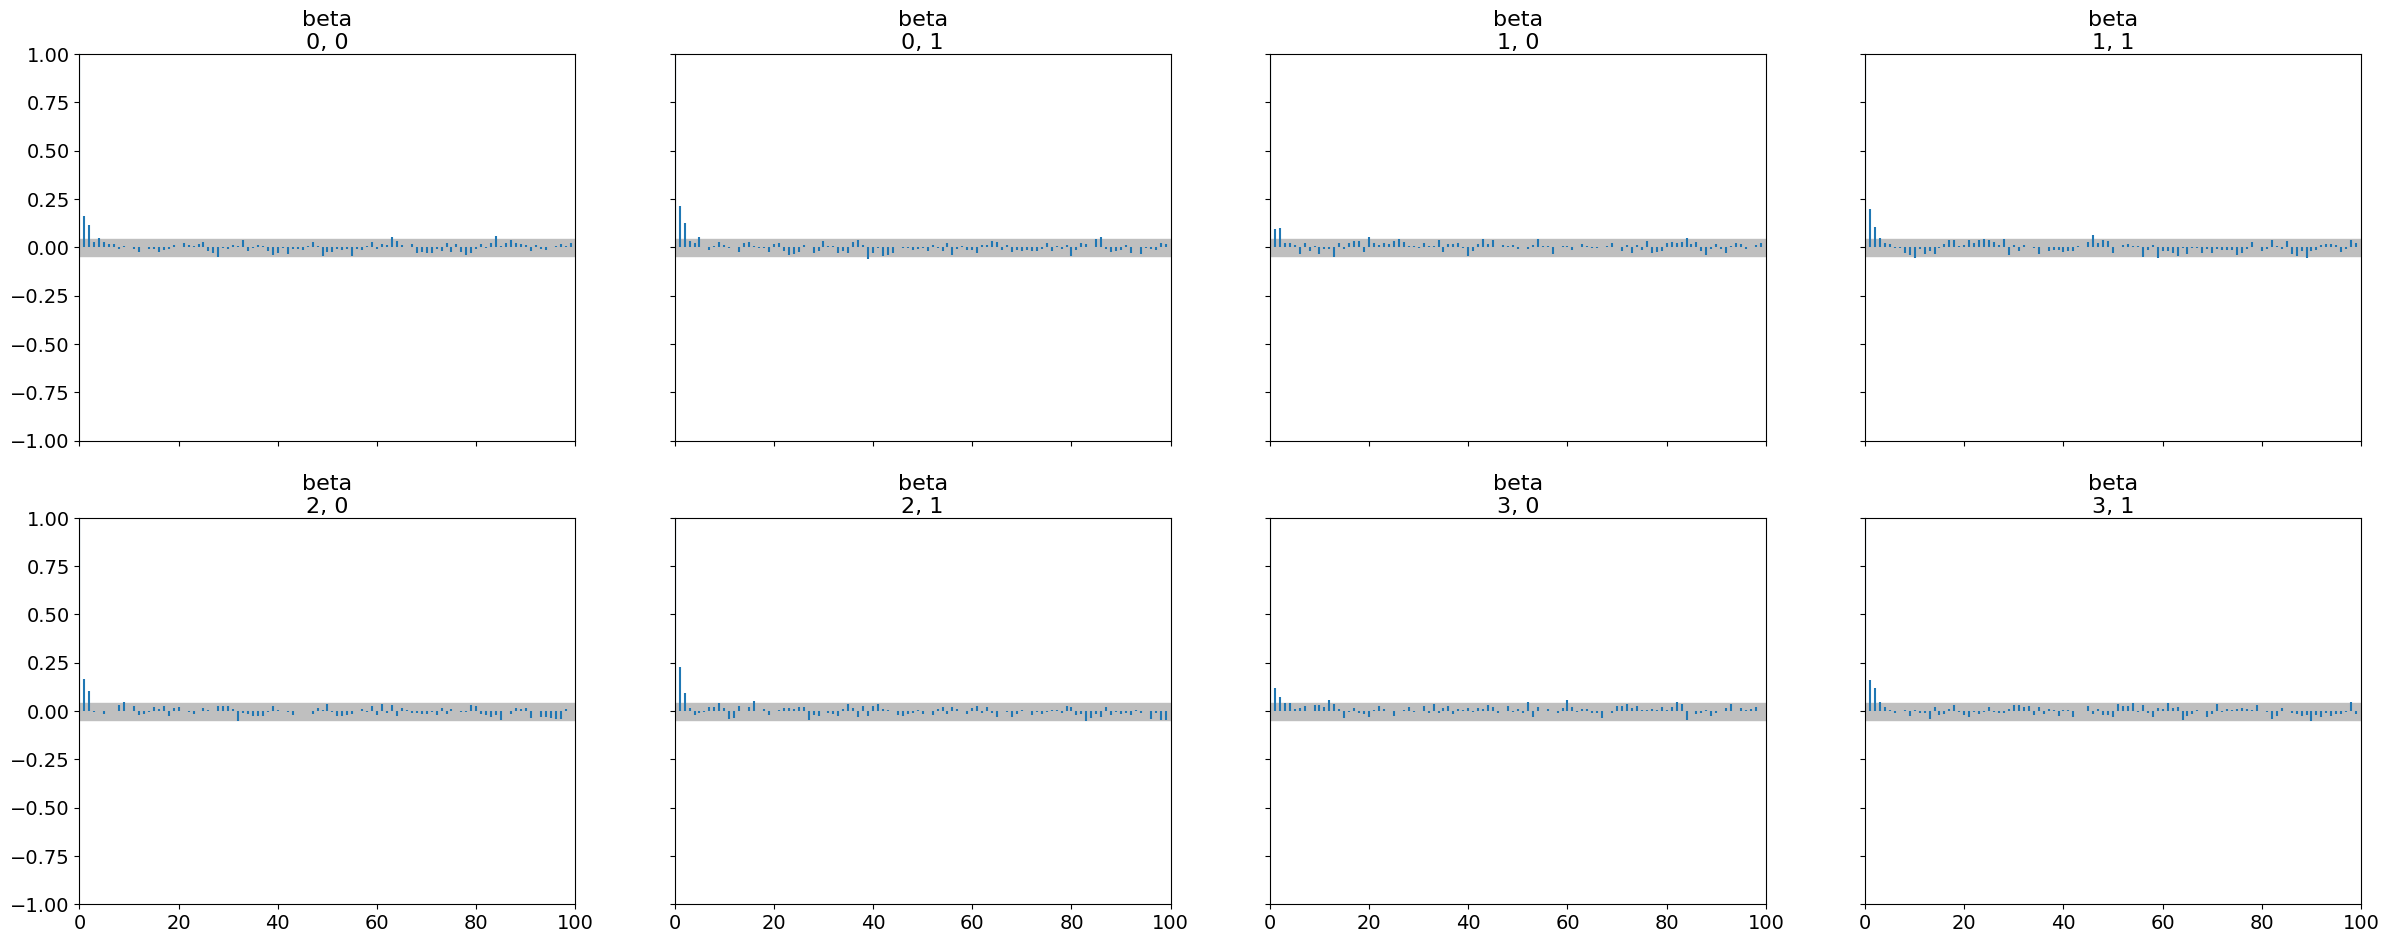

In [43]:
az.plot_autocorr(trace, var_names=["beta"])

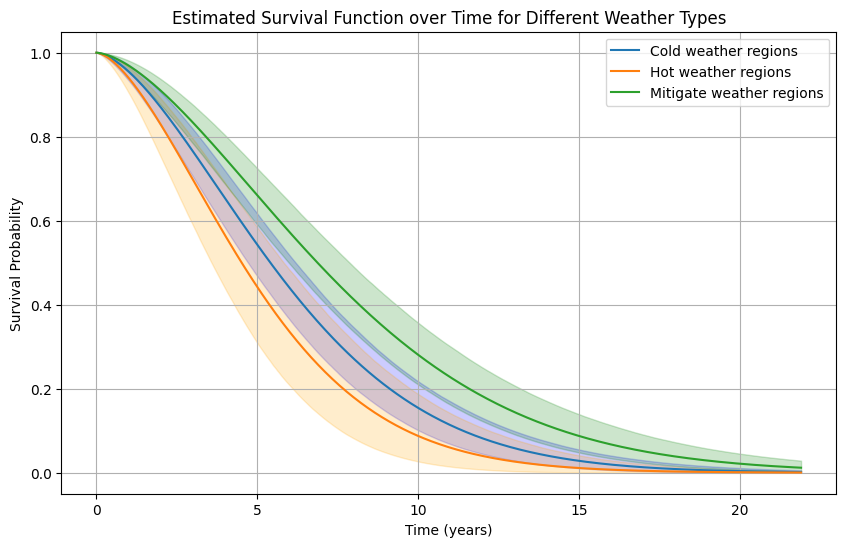

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Define the Weibull survival function
def weibull_survival_function(time, alpha, lambda_):
    return np.exp(-(time[:, None] / lambda_)**alpha)

# Define time points for evaluation
time_points_days = np.linspace(1, 8000, 500)
time_points_years = time_points_days / 365.25  # Convert days to years

# Extract posterior samples
alpha_samples = trace.posterior['rho'].values.flatten()
intercept_samples = trace.posterior['intercept'].values.flatten()
beta_samples = trace.posterior['beta'].values.reshape((-1, 2))  # Adjust shape for two beta coefficients

# Calculate lambda for each category of weather_type
lambda_samples_category_0 = np.exp(intercept_samples)  # Baseline category (implicitly 0 for all betas)
lambda_samples_category_1 = np.exp(intercept_samples + beta_samples[:, 0])  # Category 1
lambda_samples_category_2 = np.exp(intercept_samples + beta_samples[:, 1])  # Category 2

# Calculate the survival function over time for all categories
survival_category_0 = weibull_survival_function(time_points_days, alpha_samples, lambda_samples_category_0)
survival_category_1 = weibull_survival_function(time_points_days, alpha_samples, lambda_samples_category_1)
survival_category_2 = weibull_survival_function(time_points_days, alpha_samples, lambda_samples_category_2)

# Calculate mean survival function and 95% credible intervals
mean_survival_category_0 = np.mean(survival_category_0, axis=1)
mean_survival_category_1 = np.mean(survival_category_1, axis=1)
mean_survival_category_2 = np.mean(survival_category_2, axis=1)
ci_survival_category_0 = np.percentile(survival_category_0, [2.5, 97.5], axis=1)
ci_survival_category_1 = np.percentile(survival_category_1, [2.5, 97.5], axis=1)
ci_survival_category_2 = np.percentile(survival_category_2, [2.5, 97.5], axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points_years, mean_survival_category_0, label='Cold weather regions')
plt.plot(time_points_years, mean_survival_category_1, label='Hot weather regions')
plt.plot(time_points_years, mean_survival_category_2, label='Mitigate weather regions')
plt.fill_between(time_points_years, ci_survival_category_0[0], ci_survival_category_0[1], color='blue', alpha=0.2)
plt.fill_between(time_points_years, ci_survival_category_1[0], ci_survival_category_1[1], color='orange', alpha=0.2)
plt.fill_between(time_points_years, ci_survival_category_2[0], ci_survival_category_2[1], color='green', alpha=0.2)
plt.xlabel('Time (years)')
plt.ylabel('Survival Probability')
plt.title('Estimated Survival Function over Time for Different Weather Types')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
from scipy.interpolate import interp1d

# Function to calculate median survival time from survival function samples
def median_survival_time(survival_samples, time_points):
    medians = []
    for survival in survival_samples.T:
        interp_func = interp1d(survival, time_points, bounds_error=False, fill_value='extrapolate')
        medians.append(interp_func(0.5))
    return np.median(medians)

print(f"MST cold regions: {median_survival_time(survival_category_0, time_points_days/365.25)}")
print(f"MST hot regions: {median_survival_time(survival_category_1, time_points_days/365.25)}")
print(f"MST mitigate regions: {median_survival_time(survival_category_2, time_points_days/365.25)}")

MST cold regions: 5.4113985348901235
MST hot regions: 4.514512723691415
MST mitigate regions: 6.874770111916726


In [47]:
import numpy as np
from lifelines.utils import concordance_index

# Ensure data is correctly fetched
weather_type_encoded = data[['weather_type_hot_region', 'weather_type_mitigate_region']].values  # Assuming 3 categories, creating 2 dummy variables
survival_times = data['SURVIVAL_TIME'].values
events_observed = data['EVENT'].values

# Add axes for chain and draw to weather_type_encoded for broadcasting
weather_type_encoded = weather_type_encoded.T  # Transpose to align correctly
weather_type_encoded = weather_type_encoded[None, None, :, :]  # shape: (1, 1, n_covariates, n_observations)

# Fetch posterior samples of intercept and beta
intercept_samples = trace["posterior"]['intercept'].values  # shape: (n_chains, n_samples)
beta_samples = trace["posterior"]['beta'].values  # shape: (n_chains, n_samples, n_covariates)

# Compute hazard rates using broadcasting correctly
# Use einsum to handle the multiplication and summation over the covariates axis
hazard_rates_posterior = np.exp(intercept_samples[:, :, None] + np.sum(beta_samples[:, :, :, None] * weather_type_encoded, axis=2))


# Compute the median across both chains and samples, maintaining the individual observations
median_hazards = np.median(hazard_rates_posterior, axis=(0, 1))  # shape: (n_observations,)

# Ensure that the shapes of survival_times, events_observed, and median_hazards align
assert survival_times.shape[0] == median_hazards.shape[0], "Shapes of survival_times and median_hazards do not match"
assert events_observed.shape[0] == median_hazards.shape[0], "Shapes of events_observed and median_hazards do not match"

# Calculate the concordance index
c_index = concordance_index(event_times=survival_times,
                            event_observed=events_observed,
                            predicted_scores=median_hazards)

print(f'Concordance Index: {c_index:.4f}')


Concordance Index: 0.5883


## Cox Proportional Hazard (CPH) model

In [50]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("")

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(data.drop(["ROAD_SEGMENT_ID", "risk_score", "status_at_time_point", "0"], axis=1), duration_col='SURVIVAL_TIME', event_col='EVENT')

# Print the summary
cph.print_summary()



# Calculate the concordance index
c_index = cph.concordance_index_
print(f"Concordance Index: {c_index}")

<lifelines.CoxPHFitter: fitted with 208 total observations, 11 right-censored observations>
             duration col = 'SURVIVAL_TIME'
                event col = 'EVENT'
      baseline estimation = breslow
   number of observations = 208
number of events observed = 197
   partial log-likelihood = -865.95
         time fit was run = 2024-05-22 10:12:00 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
hot_region        0.28       1.33       0.23            -0.17             0.73                 0.85                 2.08
mitigate_region  -0.38       0.68       0.17            -0.72            -0.05                 0.49                 0.95
low_esal         -0.18       0.83       0.16            -0.49             0.13                 0.61                 1.13
low_thickness    -0.14       0.87       0.15            -0.44             0.16                 0.65                 1.18
low_humidity      0.04       1.04       0.27            -0.49             0.56                 0.61                 1.76
low_prec          0.04       1.04       0.27            -0.48             0.57                 0.62                 1.77

                  cmp to     z    p   -log2(p)
covariate                                     
hot_region          0.00  1.23 0.22       2.19
mitigate_region     0.00 -2.24 0.03       5.30
low_esal            0.00 -1.15 0.25       2.01
low_thickness       0.00 -0.90 0.37       1.44
low_humidity        0.00  0.14 0.89       0.17
low_prec            0.00  0.16 0.87       0.20
---
Concordance = 0.61
Partial AIC = 1743.90
log-likelihood ratio test = 17.35 on 6 df
-log2(p) of ll-ratio test = 6.95

Concordance Index: 0.6080274686242008


<Axes: xlabel='log(HR) (95% CI)'>

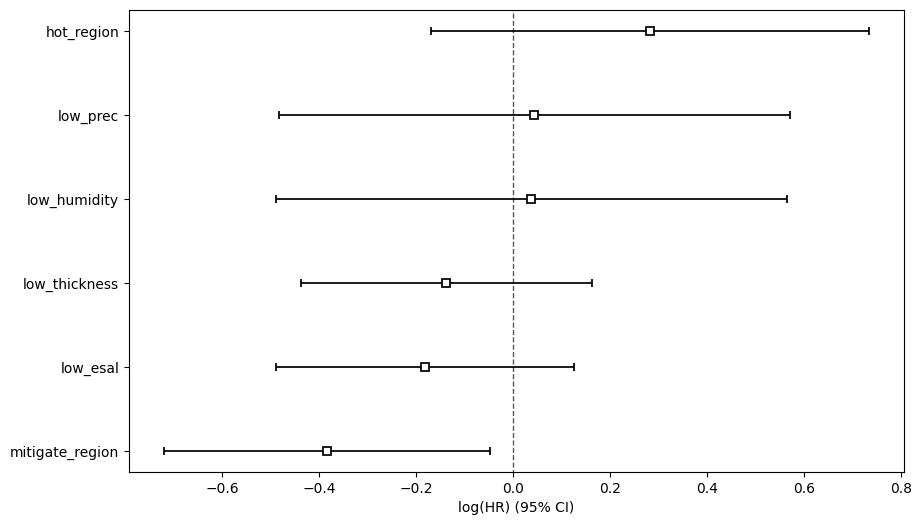

In [51]:
plt.subplots(figsize = (10, 6))
cph.plot()